In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib
import math
import numpy as np
import itertools 
from itertools import product
from collections import Counter
import garpar as gp
import re
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre
from skcriteria.ranksrev import RankInvariantChecker
from garpar.datasets import make_multisector, RissoLevyStable, RissoNormal, RissoUniform
import warnings

/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/pipeline.py:27: SKCriteriaDeprecationWarning: The 'skcriteria.pipeline' module is deprecated since 0.9 and will be removed in 1.0 Use 'skcriteria.pipelines' instead.
  deprecate.warn(
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/madm.py:30: SKCriteriaDeprecationWarning: 'skcriteria.madm' module is deprecated, use 'skcriteria.agg' instead
  utils.deprecate.warn(deprecation_reason)
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/agg/similarity.py:27: SKCriteriaDeprecationWarning: The module 'skcriteria.agg.similarity' is deprecated since v0.9 and will be removed in v1.0. Please use 'skcriteria.agg.topsis' instead.
  deprecate.warn(


In [2]:
# --- 1. Definición de Nombres (Tickers) ---
nombres_acciones = [
    "CRES", "CADO", "GARO", "INVJ",                                     # AGRO
    "CVH", "TECO2", "AUSO", "BOLT", "CTIO", "DYCA", "GAMI", "GCLA",     # COME (1-8)
    "IRSA", "OEST", "PATA", "POLL", "TGLT",                             # COME (9-13)
    "CEPU", "COME", "EDN", "PAMP", "TGNO4", "TGSU2", "TRAN", "YPFD",    # ENE (1-8)
    "CAPX", "CARC", "CECO2", "CGPA2", "DGCU2", "GBAN", "METR", "MTR",   # ENE (9-16)
    "BBAR", "BMA", "BYMA", "GGAL", "SUPV", "VALO", "BHIP", "BPAT",      # FIN
    "CELU", "GRIM", "HAVA", "INTR", "LEDE", "MOLA", "MOLI", "MORI",     # MOA (1-8)
    "RICH", "SAMI", "SEMI",                                             # MOA (9-11)
    "ALUA", "HARG", "LOMA", "MIRG", "TXAR", "AGRO", "DOME", "FERR",     # MOI (1-8)
    "FIPL", "LONG", "RIGO"                                              # MOI (9-11)
]

In [3]:
# --- 1. Configuración de Parámetros Fijos ---
NUM_ITERACIONES = 100
DIAS_SIMULACION = 100
VENTANAS_A_PROBAR = [3, 5, 7] 

# --- 2. Precios Iniciales (Lista Completa) ---
PRECIOS_INICIALES_TOTAL = [
    1515.00, 475.50, 200.00, 325.00,                      # AGRO (4)
    7000.00, 2490.00, 2725.00, 44.85, 1880.00, 840.00,    # COME (1-6)
    235.75, 2750.00, 2015.00, 710.00, 1300.00, 300.00,    # COME (7-12)
    20.90,                                                # COME (13)
    1655.00, 131.25, 1950.00, 4130.00, 3345.00, 7840.00,  # ENE (1-6)
    2630.00, 45600.00, 5150.00, 29.95, 407.00, 2420.00,   # ENE (7-12)
    1590.00, 1945.00, 2160.00, 2600.00,                   # ENE (13-16)
    7140.00, 9420.00, 206.75, 6870.00, 2830.00, 365.50,   # FIN (1-6)
    419.00, 2265.00,                                      # FIN (7-8)
    311.00, 2150.00, 5900.00, 400.00, 1010.00, 24450.00,  # MOA (1-6)
    3060.00, 224.00, 1500.00, 636.00, 25.55,              # MOA (7-11)
    787.00, 1550.00, 3195.00, 23500.00, 696.00, 49.60,    # MOI (1-6)
    70.00, 25.85, 240.00, 27.00, 670.00                   # MOI (7-11)
]
# --- DEFINICIÓN DE PARÁMETROS INDEPENDIENTES ---
# Parámetros con asimetría extrema (Skewness severa) valores de β hacia los extremos -1 y 1
#(-1 (Asimetría total hacia la izquierda (valores negativos extremos/caídas bruscas) representa caída del mercado y 1 (Asimetría total hacia la derechavalores positivos extremos).
params_AGRO = {"alpha": 1.735319, "beta": -0.950000, "mu": -0.000443, "sigma": 0.012255, "entropy": 0.99}
params_COME = {"alpha": 1.899862, "beta": 0.850000,  "mu": -0.000200, "sigma": 0.011113, "entropy": 0.99}
params_ENE  = {"alpha": 1.945898, "beta": -0.999961, "mu": -0.000073, "sigma": 0.017229, "entropy": 0.99}
params_FIN  = {"alpha": 1.857841, "beta": 0.900000, "mu": 0.000555,  "sigma": 0.018549, "entropy": 0.99}
params_MOA  = {"alpha": 1.633121, "beta": -0.880000, "mu": -0.002299, "sigma": 0.012174, "entropy": 0.99}
params_MOI  = {"alpha": 1.841531, "beta": -0.920000,  "mu": -0.001496, "sigma": 0.013477, "entropy": 0.99}

# AJUSTE AUTOMÁTICO DE STOCKS_TOTALES
STOCKS_TOTALES = len(PRECIOS_INICIALES_TOTAL) # Esto ahora será 63

# --- 3. Definición de Parámetros (Asegurando 63 entradas) ---
# Usamos multiplicadores para no equivocarnos en la cuenta
parametros_sectores_base = (
    [params_AGRO] * 4 + 
    [params_COME] * 13 + 
    [params_ENE] * 16 + 
    [params_FIN] * 8 + 
    [params_MOA] * 11 + 
    [params_MOI] * 11
)

# Verificación de seguridad
if len(parametros_sectores_base) != STOCKS_TOTALES:
    print(f"ERROR: Tienes {len(parametros_sectores_base)} parámetros pero {STOCKS_TOTALES} precios.")

# --- 4. BUCLE DE SIMULACIÓN ---
resultados_por_ventana = {ventana: [] for ventana in VENTANAS_A_PROBAR}

for VENTANA in VENTANAS_A_PROBAR:
    print(f"Iniciando {NUM_ITERACIONES} simulaciones para Ventana: {VENTANA} días...")
    
    for i in range(NUM_ITERACIONES):
        random_seed_base = i * 10000 
        distribuciones_para_corrida = []
        
        for j, params in enumerate(parametros_sectores_base):
            semilla_sector = random_seed_base + (j * 100)
            params_corrida = params.copy() 
            params_corrida['random_state'] = semilla_sector
            # Se asume que RissoLevyStable está importada correctamente
            distribuciones_para_corrida.append(RissoLevyStable(**params_corrida))

        # SIMULACIÓN DEL MERCADO
        stocksset = make_multisector(
            *distribuciones_para_corrida,
            stocks=STOCKS_TOTALES,  # Ahora es 63
            days=DIAS_SIMULACION,
            window_size=VENTANA,
            price=PRECIOS_INICIALES_TOTAL 
        )
        
        df_simulacion = stocksset._prices_df 
        resultados_por_ventana[VENTANA].append(df_simulacion)
    
print("\n--- ¡Generación de Simulaciones Finalizada! ---")

Iniciando 100 simulaciones para Ventana: 3 días...
Iniciando 100 simulaciones para Ventana: 5 días...
Iniciando 100 simulaciones para Ventana: 7 días...

--- ¡Generación de Simulaciones Finalizada! ---


In [4]:
# --- 5. Definición de Nombres de Acciones (Fuera del bucle) ---
nombres_acciones = [
    "CRES", "CADO", "GARO", "INVJ",                                     # AGRO
    "CVH", "TECO2", "AUSO", "BOLT", "CTIO", "DYCA", "GAMI", "GCLA",     # COME (1-8)
    "IRSA", "OEST", "PATA", "POLL", "TGLT",                             # COME (9-13)
    "CEPU", "COME", "EDN", "PAMP", "TGNO4", "TGSU2", "TRAN", "YPFD",    # ENE (1-8)
    "CAPX", "CARC", "CECO2", "CGPA2", "DGCU2", "GBAN", "METR", "MTR",   # ENE (9-16)
    "BBAR", "BMA", "BYMA", "GGAL", "SUPV", "VALO", "BHIP", "BPAT",      # FIN
    "CELU", "GRIM", "HAVA", "INTR", "LEDE", "MOLA", "MOLI", "MORI",     # MOA (1-8)
    "RICH", "SAMI", "SEMI",                                             # MOA (9-11)
    "ALUA", "HARG", "LOMA", "MIRG", "TXAR", "AGRO", "DOME", "FERR",     # MOI (1-8)
    "FIPL", "LONG", "RIGO"                                              # MOI (9-11)
]

# --- 6. Ensamblado: Asignación de Nombres a los DataFrames Resultantes ---
# Recorremos el diccionario generado en el paso 4 y renombramos las columnas
for ventana in VENTANAS_A_PROBAR:
    for df in resultados_por_ventana[ventana]:
        # Asignamos los nombres directamente a las columnas del DataFrame
        df.columns = nombres_acciones

print("--- Nombres de acciones integrados correctamente en todos los DataFrames ---")

--- Nombres de acciones integrados correctamente en todos los DataFrames ---


In [5]:
# --- 0. CONFIGURACIÓN INICIAL ---
# Suprimir el warning común de garpar/pypfopt sobre matrices no positivas
warnings.filterwarnings('ignore', category=UserWarning, message='The covariance matrix is non positive semidefinite. Amending eigenvalues.')
warnings.filterwarnings('ignore', category=UserWarning, message="No risk_free_rate specified, coercing it")
# ⚠️ DEFINICIÓN DE LOS OPTIMIZADORES A PROBAR (Asumida)
optimizadores_a_probar = {
  #  "max_sharpe": gp.optimize.mean_variance.MVOptimizer(model='max_sharpe'),
    "Markowitz sujeto a retorno mínimo 0.001": gp.optimize.mean_variance.Markowitz(target_return=0.001),
    "Markowitz sujeto a retorno mínimo 0.002": gp.optimize.mean_variance.Markowitz(target_return=0.002),
    "Markowitz sujeto a retorno mínimo 0.003": gp.optimize.mean_variance.Markowitz(target_return=0.003),
    "Markowitz sujeto a retorno mínimo 0.004": gp.optimize.mean_variance.Markowitz(target_return=0.004),
    "Markowitz sujeto a retorno mínimo 0.005": gp.optimize.mean_variance.Markowitz(target_return=0.005),
#    "markowitz_target_risk1": gp.optimize.mean_variance.Markowitz(target_risk=0.36),

}

rows = []

print("--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---")

# --- 1. BUCLE DE PROCESAMIENTO SOBRE LOS RESULTADOS GUARDADOS ---

for VENTANA, lista_simulaciones in resultados_por_ventana.items():
    
    for i, df_corrida in enumerate(lista_simulaciones):
        
        corrida_id = i + 1
        stocks_number_base = len(df_corrida.columns)

        # 💡 MEJORA DE ROBUSTEZ: Intentar crear el StocksSet primero
        stocksset_corrida = None
        try:
            stocksset_corrida = gp.StocksSet.from_prices(df_corrida, window_size=VENTANA)
        except Exception as e:
            # Si el StocksSet falla (ej: datos malformados), registra el fallo para TODOS los modelos
            print(f"⚠️ Error al crear StocksSet (Corrida {corrida_id}, Ventana {VENTANA}): {e}. Saltando modelos.")
            
            for opt_name in optimizadores_a_probar.keys():
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            continue # Pasa a la siguiente corrida
        
        # 2. ITERACIÓN SOBRE LOS MODELOS DE OPTIMIZACIÓN
        for opt_name, optimizador in optimizadores_a_probar.items():
            
            try:
                # 3. OPTIMIZACIÓN + PRUNING
                mopt = optimizador.optimize(stocksset_corrida).weights_prune()
                
                # 4. CÁLCULO DE MÉTRICAS (EXITOSO)
                metricas = {
                    "stocks_number": len(mopt.stocks),
                    "Cross_Entropy": mopt.div.cross_entropy(),
                    "Zheng_Entropy": mopt.div.zheng_entropy(),
                    "Div_Ratio": mopt.div.ratio(),
                    "CV_MC": (mopt.div.mrc() * mopt.weights).std() / (mopt.div.mrc() * mopt.weights).mean(),
                    "PDI": mopt.div.pdi(n_components=3, random_state=100)
                }

                # 5. GUARDAR RESULTADO EXITOSO
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name, 
                    **metricas
                })

            except Exception as e:
                #  Garantizar que la fila de identificadores se guarde
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            
# --- 2. CREACIÓN DEL DATAFRAME FINAL ---

df_metricas_simulacion = pd.DataFrame(rows)

# Esta línea ahora es segura, ya que 'rows' garantiza las claves de índice
df_metricas_simulacion = df_metricas_simulacion.set_index(["Ventana", "Corrida", "Modelo_Opt"])

print("\n--- ANÁLISIS COMPLETADO ---")
print(f"Total de resultados guardados: {len(df_metricas_simulacion)} filas.")
print(df_metricas_simulacion.head(9))


--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---


/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10


--- ANÁLISIS COMPLETADO ---
Total de resultados guardados: 1500 filas.
                                                         stocks_number  \
Ventana Corrida Modelo_Opt                                               
3       1       Markowitz sujeto a retorno mínimo 0.001             58   
                Markowitz sujeto a retorno mínimo 0.002             10   
                Markowitz sujeto a retorno mínimo 0.003              8   
                Markowitz sujeto a retorno mínimo 0.004              7   
                Markowitz sujeto a retorno mínimo 0.005             51   
        2       Markowitz sujeto a retorno mínimo 0.001             31   
                Markowitz sujeto a retorno mínimo 0.002             10   
                Markowitz sujeto a retorno mínimo 0.003             40   
                Markowitz sujeto a retorno mínimo 0.004             43   

                                                         Cross_Entropy  \
Ventana Corrida Modelo_Opt             

In [6]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==10)]

stocks_number  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001             14   
                Markowitz sujeto a retorno mínimo 0.002              9   
                Markowitz sujeto a retorno mínimo 0.003              8   
                Markowitz sujeto a retorno mínimo 0.004              7   
                Markowitz sujeto a retorno mínimo 0.005              6   

                                                         Cross_Entropy  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001       0.702431   
                Markowitz sujeto a retorno mínimo 0.002       0.746477   
                Markowitz sujeto a retorno mínimo 0.003       0.762737   
                Markowitz sujeto a retorno mínimo 0.004       0.903303   
                Markowitz sujeto a retorno mínimo 0.005       0.427834   

                                                         Zheng_Entropy  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001       2.270921   
                Markowitz sujeto a retorno mínimo 0.002       1.789074   
                Markowitz sujeto a retorno mínimo 0.003       1.524042   
                Markowitz sujeto a retorno mínimo 0.004       1.282986   
                Markowitz sujeto a retorno mínimo 0.005       1.401021   

                                                         Div_Ratio     CV_MC  \
Ventana Corrida Modelo_Opt                                                     
3       10      Markowitz sujeto a retorno mínimo 0.001   0.228315  1.283632   
                Markowitz sujeto a retorno mínimo 0.002   0.184682  1.059464   
                Markowitz sujeto a retorno mínimo 0.003   0.167380  1.059497   
                Markowitz sujeto a retorno mínimo 0.004   0.144774  0.973150   
                Markowitz sujeto a retorno mínimo 0.005   0.133125  1.370276   

                                                              PDI  
Ventana Corrida Modelo_Opt                                         
3       10      Markowitz sujeto a retorno mínimo 0.001  2.261662  
                Markowitz sujeto a retorno mínimo 0.002  2.232355  
                Markowitz sujeto a retorno mínimo 0.003  2.217964  
                Markowitz sujeto a retorno mínimo 0.004  2.200283  
                Markowitz sujeto a retorno mínimo 0.005  2.175418

In [7]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==12)].droplevel('Ventana').droplevel('Corrida')

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Modelo_Opt,,,,,,
Markowitz sujeto a retorno mínimo 0.001,18,3.516582,1.420634,0.190035,2.731883,1.775652
Markowitz sujeto a retorno mínimo 0.002,7,1.109467,1.013811,0.160532,1.018053,2.547905
Markowitz sujeto a retorno mínimo 0.003,6,0.565918,1.315000,0.143438,1.118162,2.514918
Markowitz sujeto a retorno mínimo 0.004,59,9.065476,1.201243,0.136896,4.459950,1.878321
Markowitz sujeto a retorno mínimo 0.005,5,0.474572,1.110704,0.127025,1.204587,2.440750


In [8]:
#Eliminar corridas con NaN ===
# =========================================================================

# 1. Identificar el nivel del índice que representa la "corrida"
LEVEL_CORRIDA = 'Corrida' 

# 2. Inicializar una lista para guardar las corridas (índices) que deben eliminarse
corridas_a_eliminar = set()

# 3. Iterar sobre las corridas (grupos) para verificar NaNs
for corrida_id, group_df in df_metricas_simulacion.groupby(level=LEVEL_CORRIDA):
    
    # 4. Verificar si existe AL MENOS UN NaN en CUALQUIERA de las filas
    # .isnull() crea un DF booleano, .any(axis=None) verifica si hay True en todo el grupo.
    if group_df.isnull().any().any(): 
        # Si se encuentra un NaN, se añade el ID de la corrida a la lista de eliminación
        corridas_a_eliminar.add(corrida_id)

# 5. Filtrar el DataFrame original, excluyendo las corridas identificadas
# Creamos una máscara booleana: True para las corridas que NO están en la lista
mascara_mantener = ~df_metricas_simulacion.index.get_level_values(LEVEL_CORRIDA).isin(corridas_a_eliminar)

# Aplicar la máscara al DataFrame
df_metricas_limpio = df_metricas_simulacion[mascara_mantener]


In [9]:
df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].describe()

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,19.931034,2.687251,1.719446,0.163105,2.092570,1.693987
std,19.561903,3.361783,0.533619,0.040816,1.378374,0.352104
min,3.000000,0.019766,0.028412,0.063132,0.268344,1.011479
25%,8.000000,0.566372,1.427583,0.134687,1.213962,1.402187
50%,10.000000,0.839418,1.719099,0.159885,1.542159,1.712463
75%,22.500000,4.095792,1.958490,0.188923,2.336594,1.878844
max,63.000000,12.578041,4.123226,0.306658,7.922977,2.745055


In [10]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 3
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_3 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v3 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v3


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [11]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v3:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_3[df_ventana_3.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]


/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,58.0,8.519595,2.111356,0.204033,2.486806,1.356269
Markowitz sujeto a retorno mínimo 0.002,10.0,0.274832,2.108017,0.164242,1.288756,1.634321
Markowitz sujeto a retorno mínimo 0.003,8.0,0.247896,1.880901,0.145362,1.219619,1.616555
Markowitz sujeto a retorno mínimo 0.004,7.0,0.251036,1.718315,0.137300,1.162621,1.602909
Markowitz sujeto a retorno mínimo 0.005,51.0,10.705639,1.531688,0.131428,3.951414,2.127076


In [12]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v3 = pd.concat(resultados_similaridad)
df_similaridad_total_v3.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v3

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.527215,0.596937,0.582226,0.574834,0.379670
2,0.394116,0.524898,0.370503,0.394686,0.491711
3,0.416466,0.645204,0.608909,0.600295,0.582128
4,0.457065,0.555861,0.622583,0.562409,0.501061
5,0.413539,0.661945,0.624828,0.603138,0.578651
...,...,...,...,...,...
95,0.636524,0.598697,0.376531,0.551310,0.350682
96,0.722748,0.658545,0.330824,0.322531,0.368296
97,0.464890,0.405704,0.165364,0.554318,0.540097


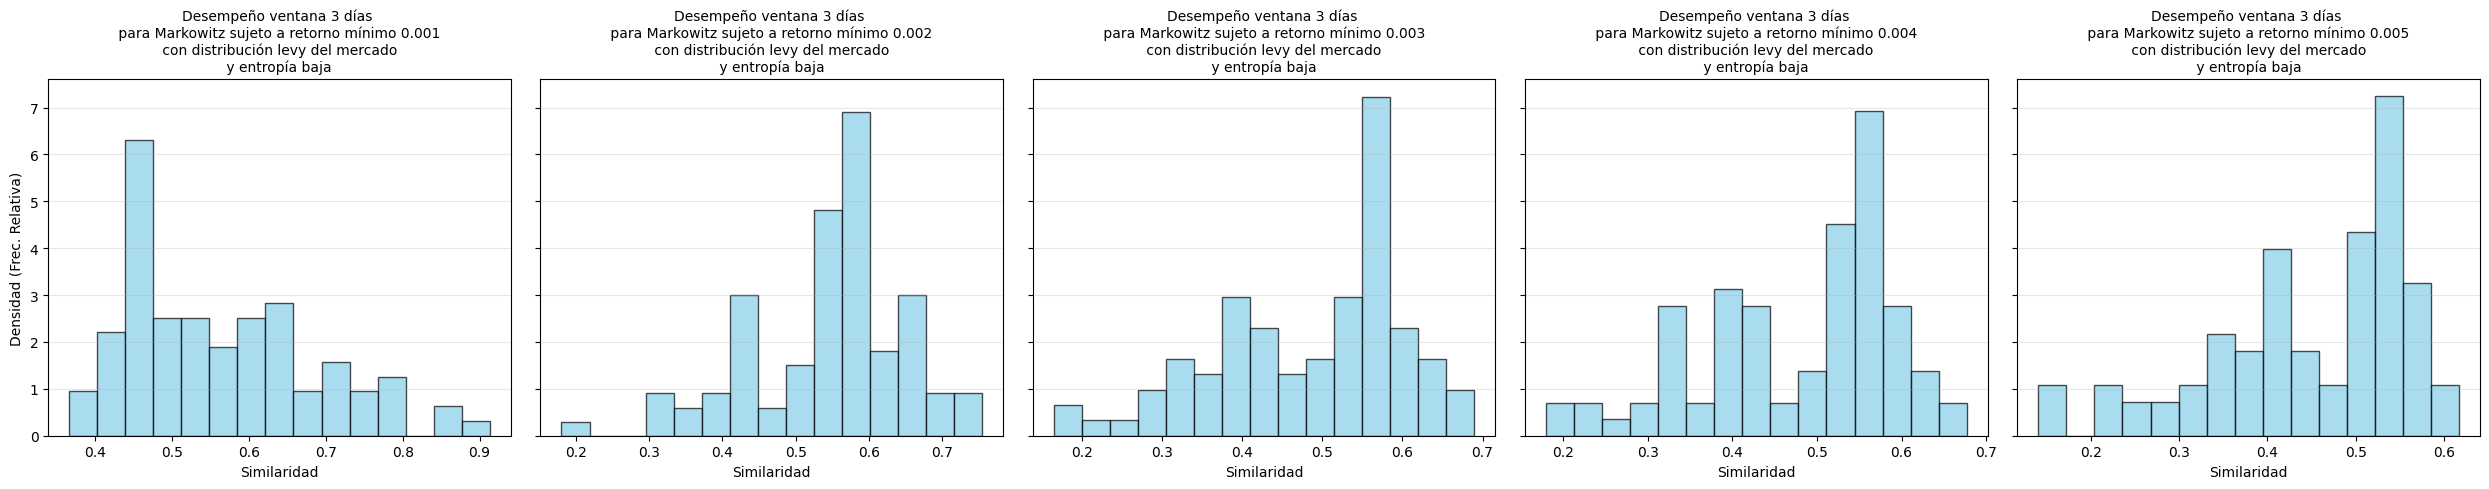

In [13]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v3.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v3[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 3 días \n para {modelo} \n con distribución levy del mercado \n y entropía baja ', fontsize=10)

    ax.set_xlabel('Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [14]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 5
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_5 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v5 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v5


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [15]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v5:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_5[df_ventana_5.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]

/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,47.0,6.939082,2.263707,0.240522,2.310835,1.163301
Markowitz sujeto a retorno mínimo 0.002,9.0,0.470820,1.878593,0.184824,0.922790,1.695506
Markowitz sujeto a retorno mínimo 0.003,9.0,0.308234,1.958061,0.159754,1.144287,1.695506
Markowitz sujeto a retorno mínimo 0.004,7.0,0.375900,1.647337,0.147872,0.920848,1.691902
Markowitz sujeto a retorno mínimo 0.005,61.0,9.396141,1.474979,0.138584,3.858185,1.386211


In [16]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v5 = pd.concat(resultados_similaridad)
df_similaridad_total_v5.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v5

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.512631,0.593642,0.583668,0.572937,0.399310
2,0.417662,0.567963,0.415482,0.442925,0.466346
3,0.422885,0.604574,0.592701,0.579443,0.557402
4,0.409668,0.419622,0.562504,0.429053,0.589121
5,0.473519,0.552797,0.486251,0.395724,0.525606
...,...,...,...,...,...
95,0.918798,0.312716,0.633317,0.579106,0.590591
96,0.577281,0.457604,0.416257,0.484979,0.481332
97,0.627733,0.416905,0.428153,0.322939,0.364822


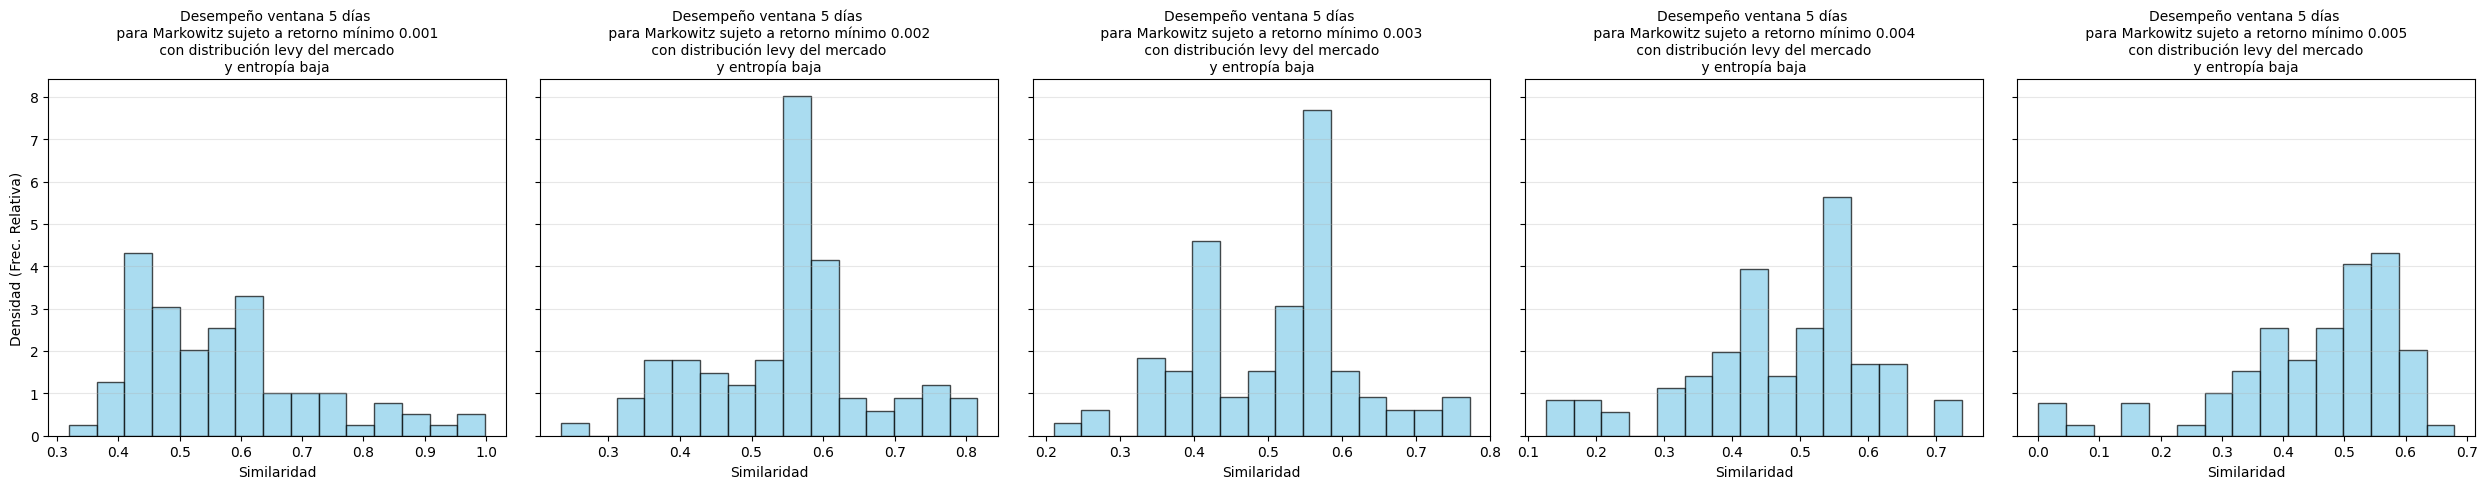

In [17]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v5.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v5[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 5 días \n para {modelo} \n con distribución levy del mercado \n y entropía baja ', fontsize=10)

    ax.set_xlabel('Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [18]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 7
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_7 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v7 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v7

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [19]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v5:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_7[df_ventana_7.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]

/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,26.0,4.944926,2.267961,0.241099,1.659557,2.134576
Markowitz sujeto a retorno mínimo 0.002,12.0,0.305724,2.262167,0.204989,1.113559,1.628108
Markowitz sujeto a retorno mínimo 0.003,10.0,0.265231,2.107107,0.183690,1.150783,1.620221
Markowitz sujeto a retorno mínimo 0.004,10.0,0.243275,2.085663,0.170447,1.235219,1.620221
Markowitz sujeto a retorno mínimo 0.005,8.0,0.296327,1.812572,0.162897,1.040491,1.607834


In [20]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v7 = pd.concat(resultados_similaridad)
df_similaridad_total_v7.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v7

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.381788,0.681350,0.647852,0.642226,0.615632
2,0.536487,0.419299,0.356970,0.398174,0.492783
3,0.375758,0.694342,0.637892,0.623425,0.624268
4,0.347187,0.687426,0.675418,0.664387,0.650671
5,0.598233,0.532085,0.504748,0.180597,0.348527
...,...,...,...,...,...
95,0.476162,0.655795,0.589981,0.464144,0.530921
96,0.463392,0.533013,0.531707,0.550757,0.534998
97,0.578151,0.535229,0.497591,0.357147,0.443208


In [21]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v7 = pd.concat(resultados_similaridad)
df_similaridad_total_v7.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v7

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.381788,0.681350,0.647852,0.642226,0.615632
2,0.536487,0.419299,0.356970,0.398174,0.492783
3,0.375758,0.694342,0.637892,0.623425,0.624268
4,0.347187,0.687426,0.675418,0.664387,0.650671
5,0.598233,0.532085,0.504748,0.180597,0.348527
...,...,...,...,...,...
95,0.476162,0.655795,0.589981,0.464144,0.530921
96,0.463392,0.533013,0.531707,0.550757,0.534998
97,0.578151,0.535229,0.497591,0.357147,0.443208


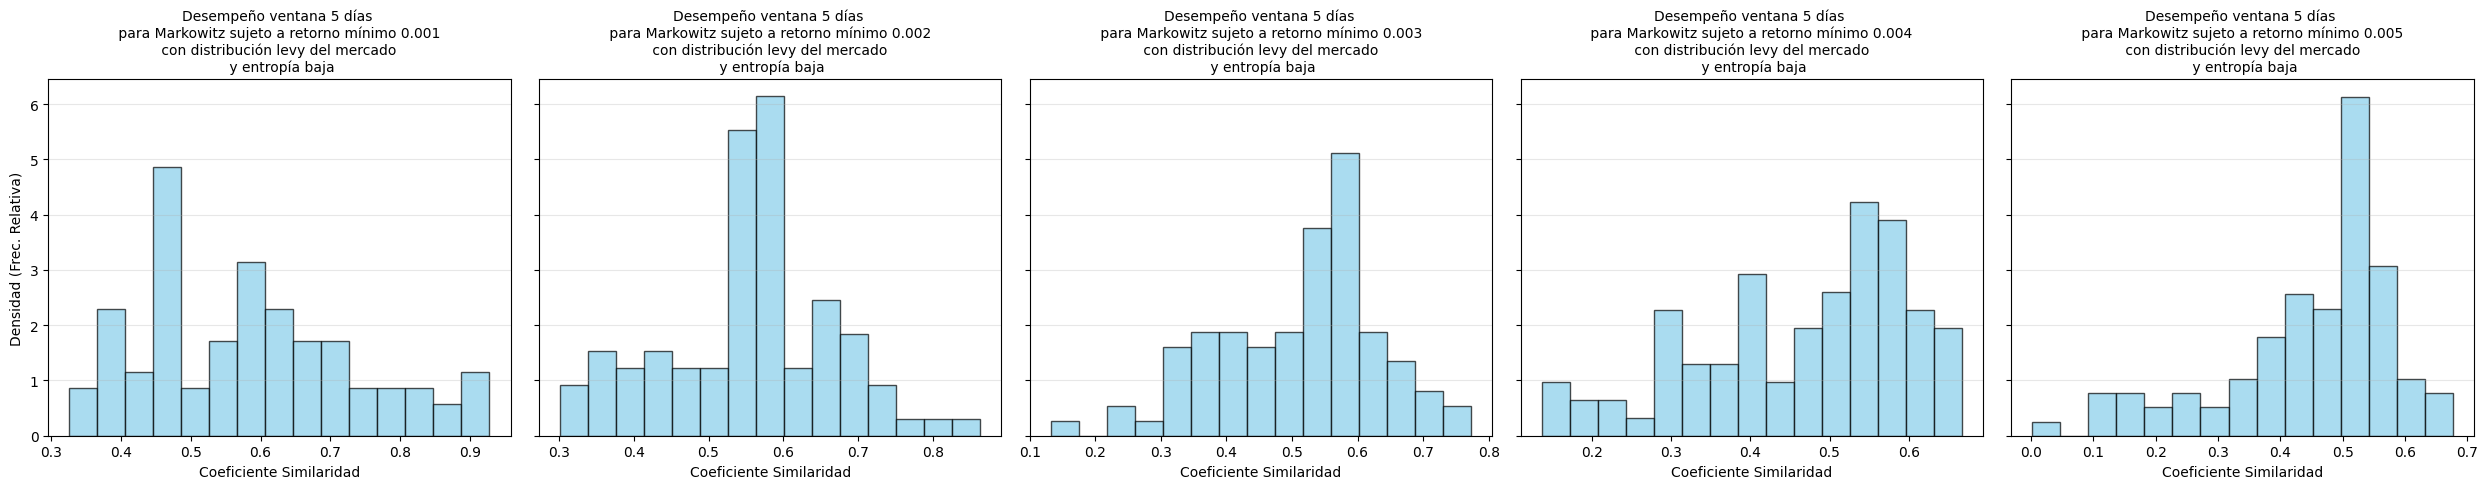

In [22]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v7.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v7[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 5 días \n para {modelo} \n con distribución levy del mercado \n y entropía baja' , fontsize=10)

    ax.set_xlabel('Coeficiente Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

/tmp/ipykernel_5019/2252457736.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_similaridad_total_v3.columns, rotation=90)
/tmp/ipykernel_5019/2252457736.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_similaridad_total_v5.columns, rotation=90)
/tmp/ipykernel_5019/2252457736.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_similaridad_total_v7.columns, rotation=90)


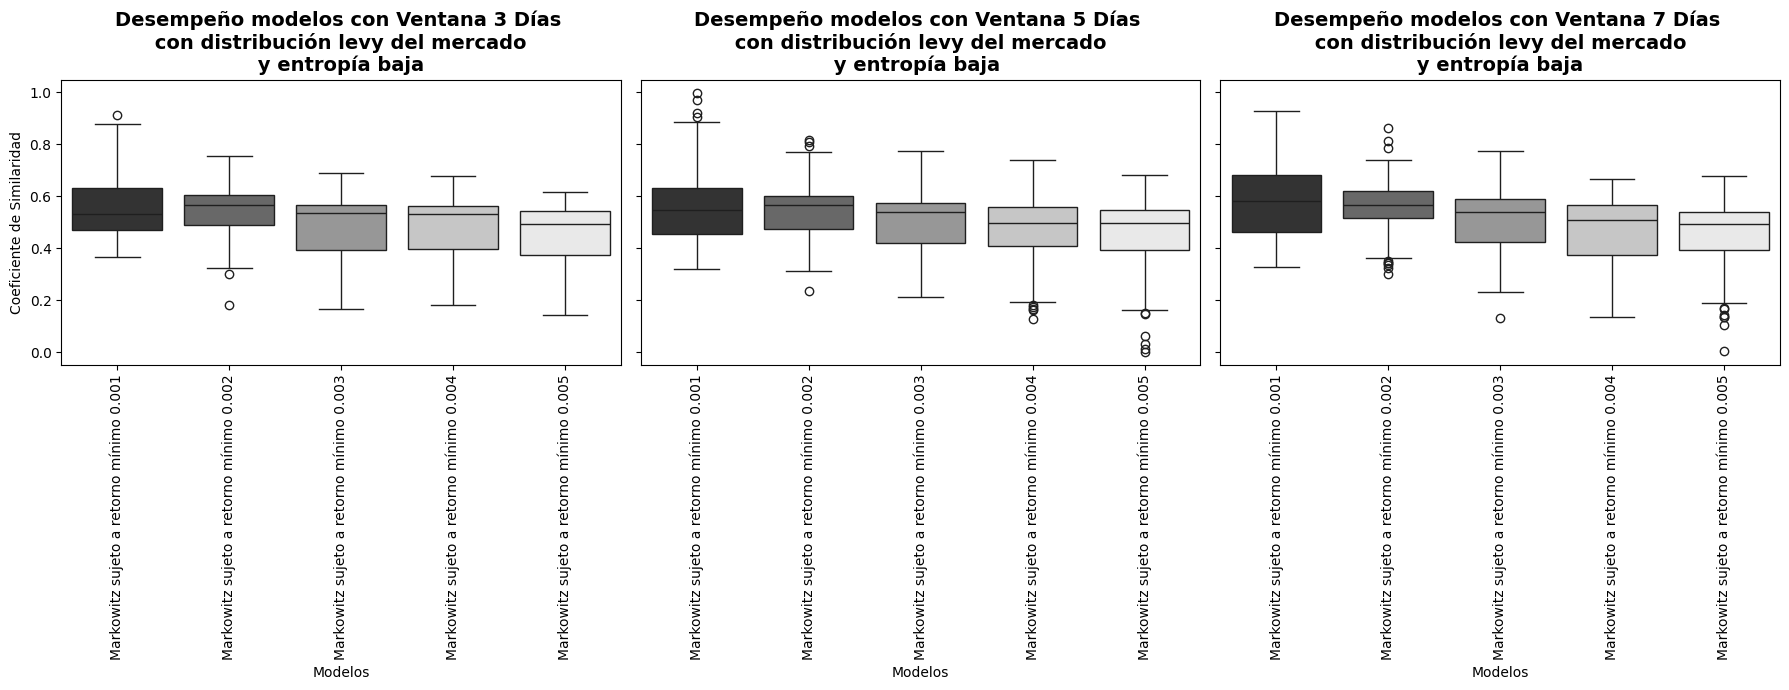

In [23]:


# 1. Configuración de la figura: 1 fila, 2 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

# 2. Gráfico 1: Ventana 3 días
sns.boxplot(
    data=df_similaridad_total_v3, 
    ax=axes[0], 
    palette="Greys_r"
)
axes[0].set_title('Desempeño modelos con Ventana 3 Días \n con distribución levy del mercado \n y entropía baja ', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(df_similaridad_total_v3.columns, rotation=90)
axes[0].set_ylabel('Coeficiente de Similaridad')
axes[0].set_xlabel('Modelos')

# 3. Gráfico 2: Ventana 5 días
sns.boxplot(
    data=df_similaridad_total_v5, 
    ax=axes[1], 
    palette="Greys_r"
)
axes[1].set_title('Desempeño modelos con Ventana 5 Días \n con distribución levy del mercado \n y entropía baja  ', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(df_similaridad_total_v5.columns, rotation=90)
axes[1].set_ylabel('') # Quitamos el label porque comparten eje Y
axes[1].set_xlabel('Modelos')

# 3. Gráfico 3: Ventana 5 días
sns.boxplot(
    data=df_similaridad_total_v7, 
    ax=axes[2], 
    palette="Greys_r"
)
axes[2].set_title('Desempeño modelos con Ventana 7 Días \n con distribución levy del mercado \n y entropía baja ', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(df_similaridad_total_v7.columns, rotation=90)
axes[2].set_ylabel('') # Quitamos el label porque comparten eje Y
axes[2].set_xlabel('Modelos')


# Ajustes finales
plt.tight_layout()
plt.show()

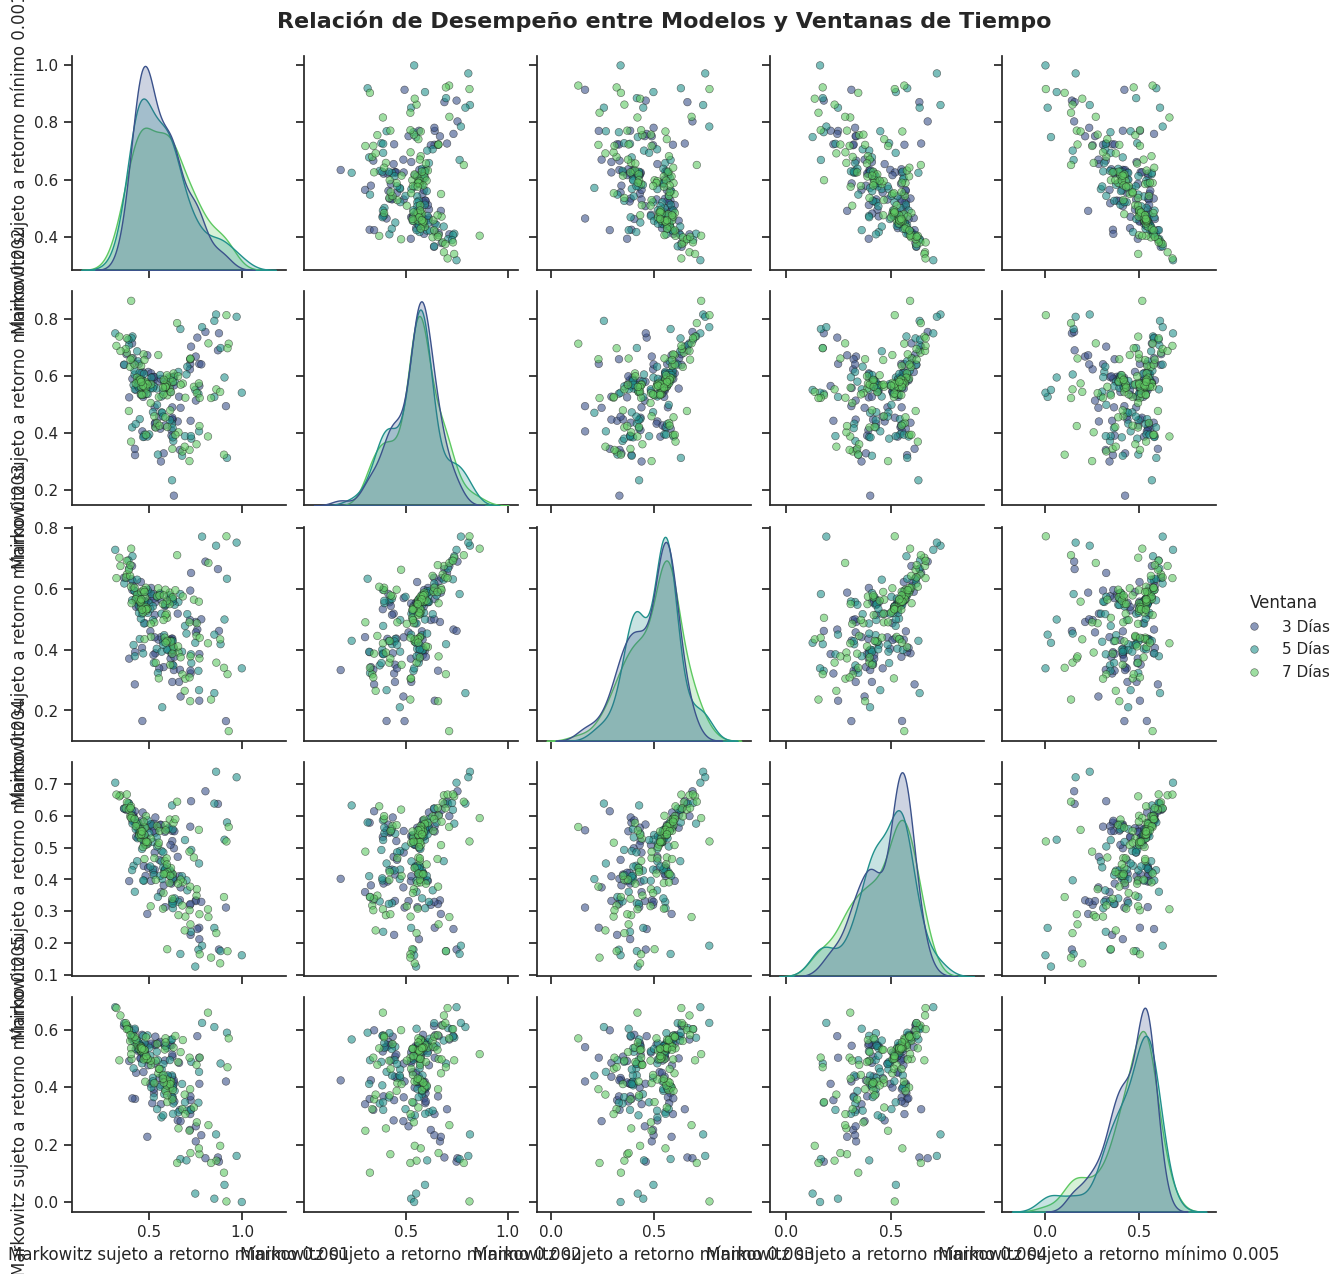

In [24]:
# 1. Preparación: Añadimos la etiqueta de "Ventana" a cada DataFrame
# Hacemos una copia para no modificar los originales
df3 = df_similaridad_total_v3.copy()
df5 = df_similaridad_total_v5.copy()
df7 = df_similaridad_total_v7.copy()

df3['Ventana'] = '3 Días'
df5['Ventana'] = '5 Días'
df7['Ventana'] = '7 Días'

# 2. Concatenamos los tres DataFrames en uno solo
df_total = pd.concat([df3, df5, df7], ignore_index=True)

# 3. Configuración del estilo
sns.set_theme(style="ticks")

# 4. Creación del Pairplot
# El 'hue' será la Ventana. Esto comparará cómo correlacionan los modelos entre sí
# y mostrará la distribución (KDE) en la diagonal.
g = sns.pairplot(
    df_total, 
    hue="Ventana", 
    palette="viridis", 
    diag_kind="kde",
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'}, # Ajustes para los puntos
    height=2.5
)

# Añadir título general
g.fig.suptitle('Relación de Desempeño entre Modelos y Ventanas de Tiempo', y=1.02, fontsize=16, fontweight='bold')

plt.show()

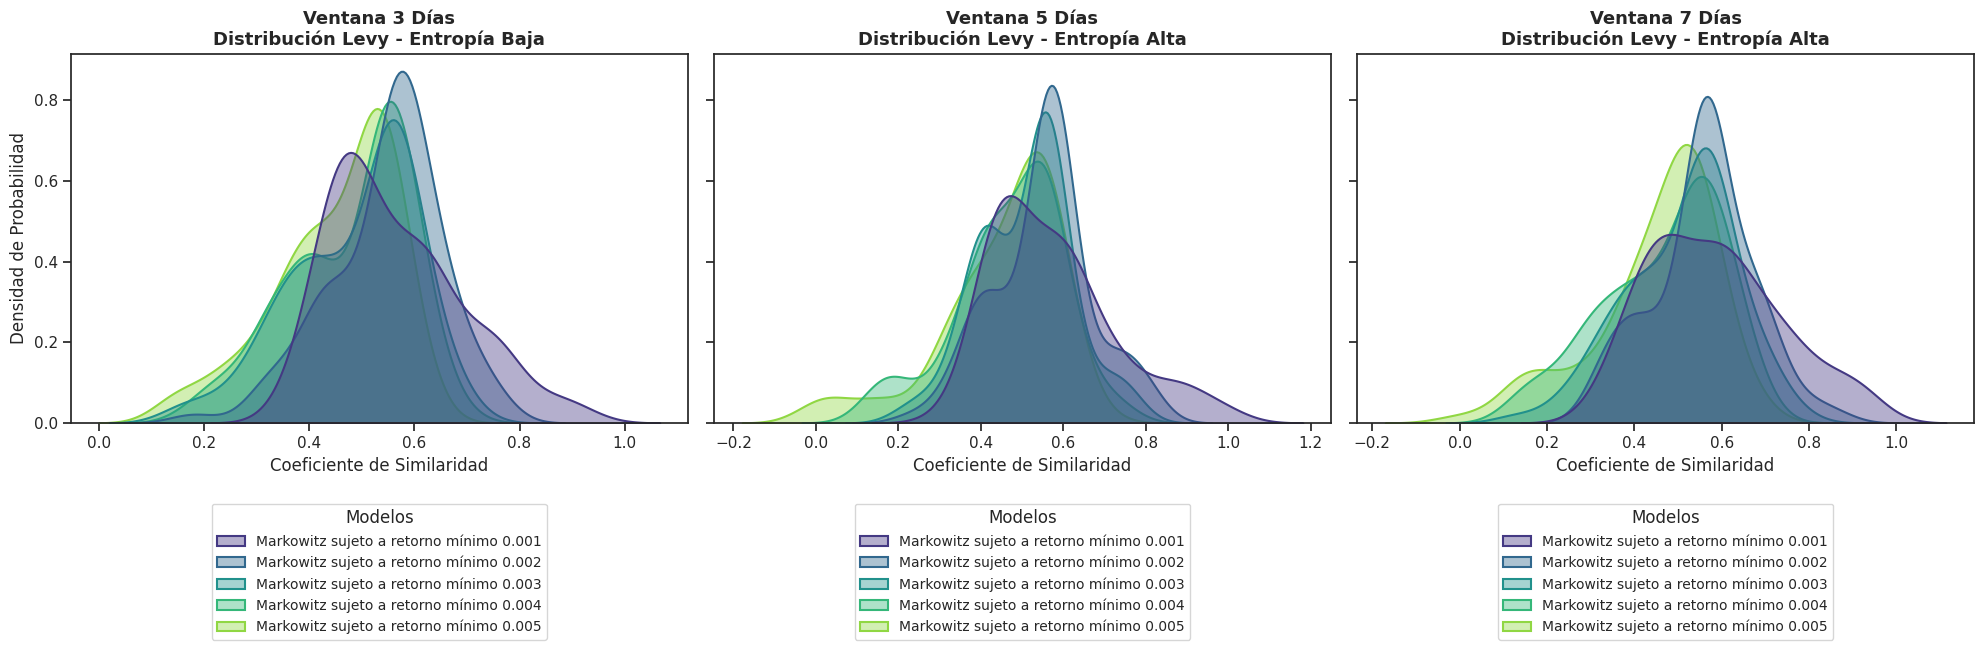

In [25]:
# 1. Configuración de la figura: 1 fila, 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Lista de dataframes y sus títulos correspondientes
dfs = [df_similaridad_total_v3, df_similaridad_total_v5, df_similaridad_total_v7]
titulos = [
    'Ventana 3 Días\nDistribución Levy - Entropía Baja',
    'Ventana 5 Días\nDistribución Levy - Entropía Alta',
    'Ventana 7 Días\nDistribución Levy - Entropía Alta'
]

# 2. Iterar sobre los ejes y los datos para generar los KDEs
for i, df in enumerate(dfs):
    # Convertimos de formato ancho a largo para que Seaborn reconozca los modelos como categorías
    df_long = df.melt(var_name='Modelo', value_name='Similaridad')
    
    sns.kdeplot(
        data=df_long,
        x="Similaridad",
        hue="Modelo",
        fill=True,
        ax=axes[i],
        palette="viridis", # Una paleta colorida ayuda a diferenciar modelos
        alpha=0.4,
        linewidth=1.5
    )
    
    axes[i].set_title(titulos[i], fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Coeficiente de Similaridad')
    
    # Solo el primer gráfico lleva etiqueta en el eje Y
    if i == 0:
        axes[i].set_ylabel('Densidad de Probabilidad')
    else:
        axes[i].set_ylabel('')

# 3. Ajustes de la leyenda para que no tape el gráfico si hay muchos modelos
for ax in axes:
    sns.move_legend(ax,  fontsize='small', title="Modelos",  loc='upper center', bbox_to_anchor=(0.5, -0.2))

# Ajustes finales
plt.tight_layout()
plt.show()

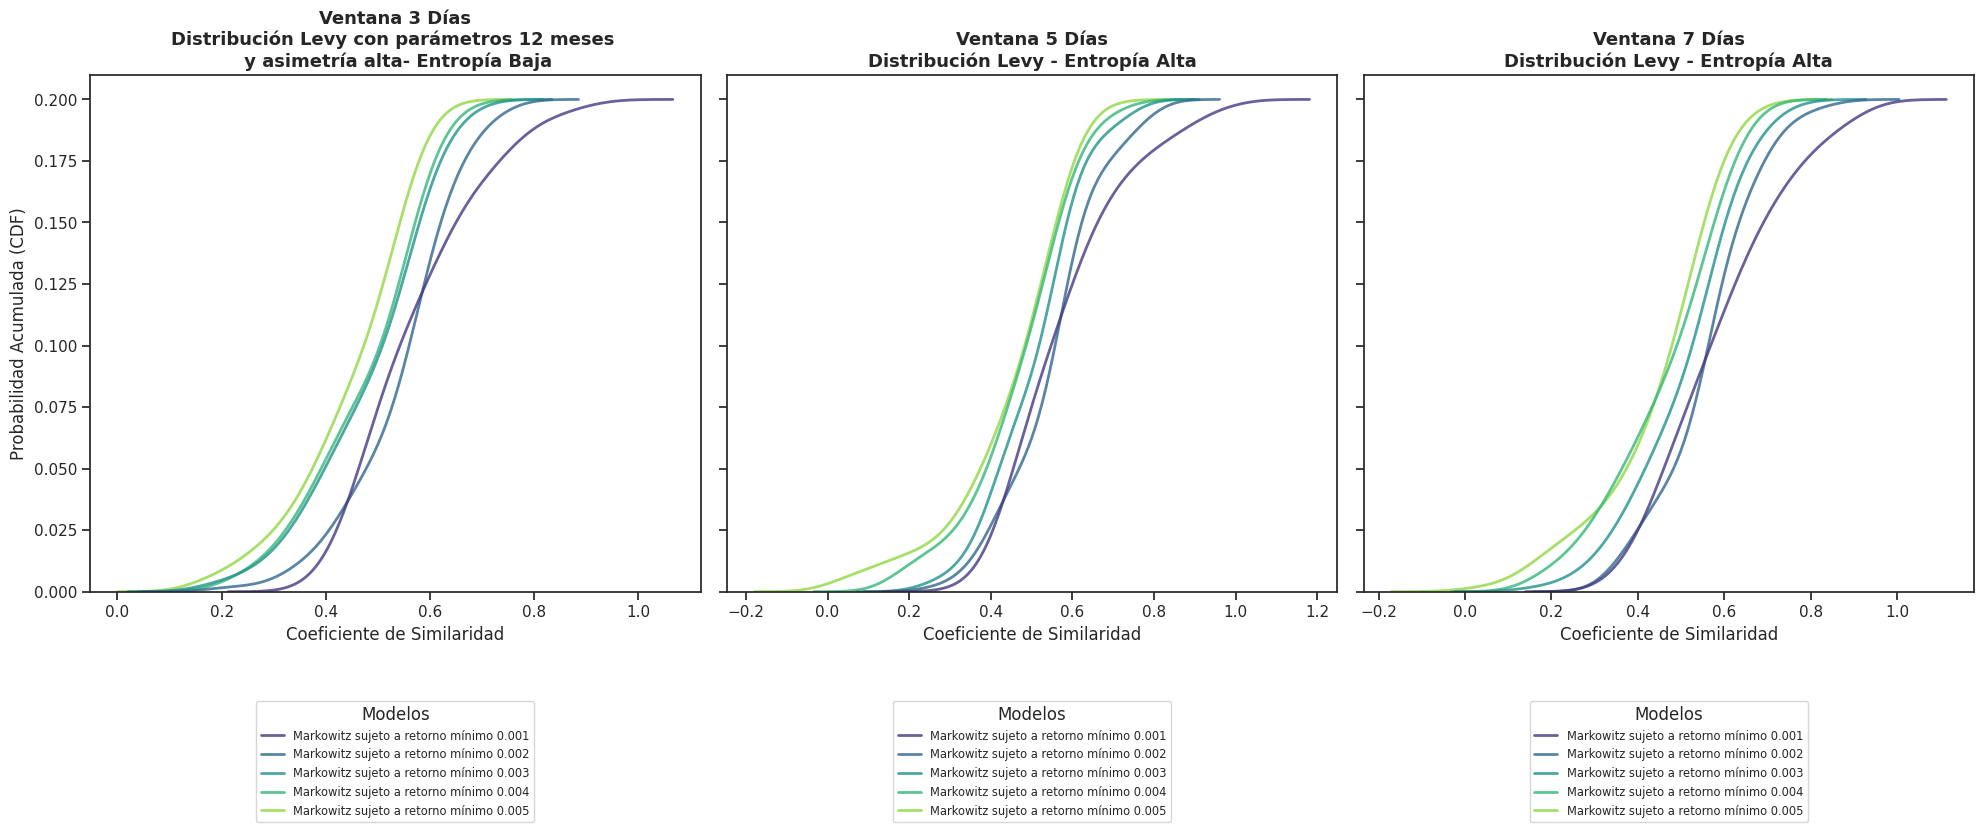

In [26]:
# 1. Configuración de la figura: 1 fila, 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Lista de dataframes y sus títulos correspondientes
dfs = [df_similaridad_total_v3, df_similaridad_total_v5, df_similaridad_total_v7]
titulos = [
    'Ventana 3 Días\nDistribución Levy con parámetros 12 meses \n y asimetría alta- Entropía Baja',
    'Ventana 5 Días\nDistribución Levy - Entropía Alta',
    'Ventana 7 Días\nDistribución Levy - Entropía Alta'
]

# 2. Iterar sobre los ejes y los datos para generar las distribuciones acumuladas
for i, df in enumerate(dfs):
    # Convertimos de formato ancho a largo
    df_long = df.melt(var_name='Modelo', value_name='Similaridad')
    
    sns.kdeplot(
        data=df_long,
        x="Similaridad",
        hue="Modelo",
        cumulative=True,     # Activamos la distribución acumulada
        fill=False,          # Solo mostramos la línea
        ax=axes[i],
        palette="viridis",
        linewidth=2,
        alpha=0.8
    )
    
    axes[i].set_title(titulos[i], fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Coeficiente de Similaridad')
    
    if i == 0:
        axes[i].set_ylabel('Probabilidad Acumulada (CDF)')
    else:
        axes[i].set_ylabel('')

# 3. Ajustes de la leyenda abajo para no obstruir las líneas
for ax in axes:
    sns.move_legend(
        ax, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2), 
        ncol=1,             # Agrupamos en 5 columnas para que sea legible
        fontsize='x-small', 
        title="Modelos"
    )

# Ajustes finales de espaciado
plt.tight_layout()
plt.subplots_adjust(bottom=0.25) # Espacio para la leyenda
plt.show()